 # Cardiovascular Heart Failure Prediction
    
   
 ## Dataset

[1] https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5#Sec2




### Libraries and Utilities

In [1]:
# Import the required libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from collections import Counter

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [4]:
from ReusableUtils import ReusableUtils
utils = ReusableUtils()

### Set Notebook Configuration Parameters

In [5]:
utils.setNotebookConfigParams()

### Utility Functions

### Import Data

In [6]:
heart_faliure_data = pd.read_csv(filepath_or_buffer = './heart_failure_clinical_records_dataset.csv',
                                 low_memory = False,
                                 skipinitialspace = True,
                                 float_precision = 'round_trip')

heart_faliure_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [7]:
heart_faliure_data.shape

(299, 13)

In [8]:
# Check the total missing values in each column.
print("Total NULL Values in each columns")
print(heart_faliure_data.isnull().sum())

Total NULL Values in each columns
age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


*** There are no missing values in the dataset***

In [9]:
heart_faliure_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0


## Data Preparation

### Test - Train Split

In [10]:

X = heart_faliure_data[['ejection_fraction', 'serum_creatinine', 'age']]


y = heart_faliure_data[['DEATH_EVENT']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, test_size = 0.10, random_state = 109)

print("X_Train Shape:", X_train.shape)
print("Y_Train Shape:", y_train.shape)
print("X_Test Shape:", X_test.shape)
print("Y_Test Shape:", y_test.shape)

X_Train Shape: (269, 3)
Y_Train Shape: (269, 1)
X_Test Shape: (30, 3)
Y_Test Shape: (30, 1)


#### Data Value Counts

In [11]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({0: 186, 1: 83})




**`1. As we see in the training data, the number of 1s (83 - Death Event) are much less comapred to the number of 0s (171 - Survival Case).`**

**`2. With this imbalance dataset (67.89% survival cases & 32.11% death events), the model could become more inclined towards learnign and predicting the negative examples than the positive (death) cases.`**

**`3. To avoid this scenario and create an un-biased model, the dataset should be balanced where we need to generate more  examples of the minority class. We need to apply the Synthetic Minority Oversampling Technique (SMOTE) algorithm on the training data such that more examples of the death events are generated and we have a balanced dataset.`**

In [12]:
print('Original dataset shape %s' % Counter(y_train.values.ravel()))

Original dataset shape Counter({0: 186, 1: 83})


In [13]:
data_features = dict(enumerate(X.columns))
data_features

{0: 'ejection_fraction', 1: 'serum_creatinine', 2: 'age'}

#### Synthetic Minority Oversampling Technique (SMOTE)

In [14]:
# Implement SMOTE
sampling = SMOTE(random_state = 100)
X_train, y_train = sampling.fit_resample(X_train.values, y_train.values.ravel())

# Shuffle the data
perms = np.random.permutation(X_train.shape[0])
X_train = X_train[perms]
y_train = y_train[perms]

X_train = pd.DataFrame(data = X_train)
y_train = pd.DataFrame(data = y_train)

print(X_train.shape)
print(y_train.shape)

(372, 3)
(372, 1)


In [15]:
print('Resampled dataset shape %s' % Counter(y_train.values.ravel()))
print('Test dataset shape %s' % Counter(y_test.values.ravel()))

Resampled dataset shape Counter({0: 186, 1: 186})
Test dataset shape Counter({0: 17, 1: 13})




**`1. With the application of SMOTE on the training data, the number of 1s (Death Event) are now equal to the number of 0s (Survival Case) with each 171 records respectively.`**

- **2. This will ensure  -**
    - 2.1 There are equal data points for both positive and negative scenarios and we have a balanced dataset.
    - 2.2 The model will not be biased during training phase by seeing more example of Survival scenarios.


### Data Normalization

In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Model Building & Training

To predict patients survival due to heart failure, I will train models from different machine learning algorithms. The classifiers to be used in this study will be -

**`1. Support Vector Machines with RBF kernel`**

**`2. Decision Tree`**

**`3. Random Forest`**

**`4. Gradient Boosting - XGBoost`**

**`5. Light GBM`**

## 1. Support Vector Machines with RBF kernel

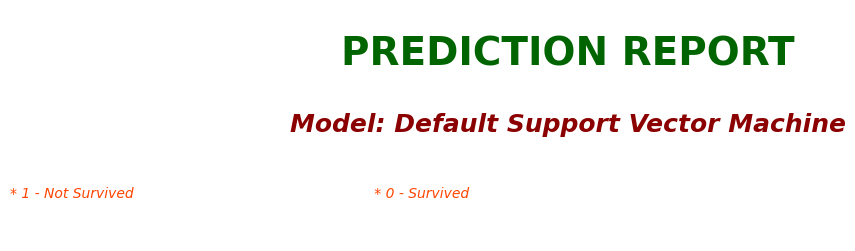

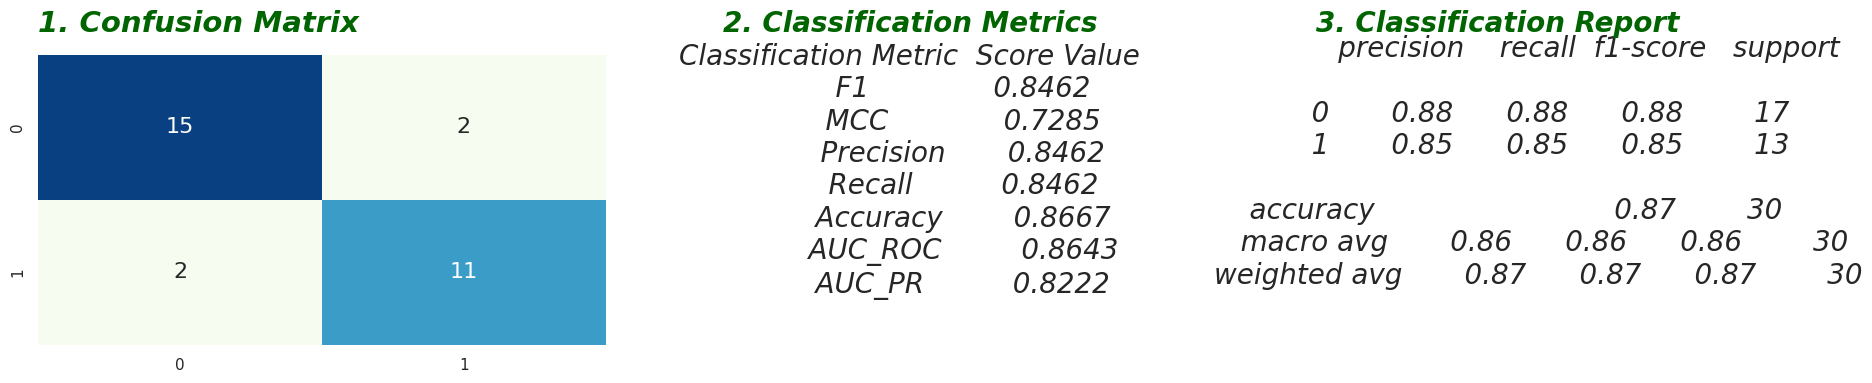

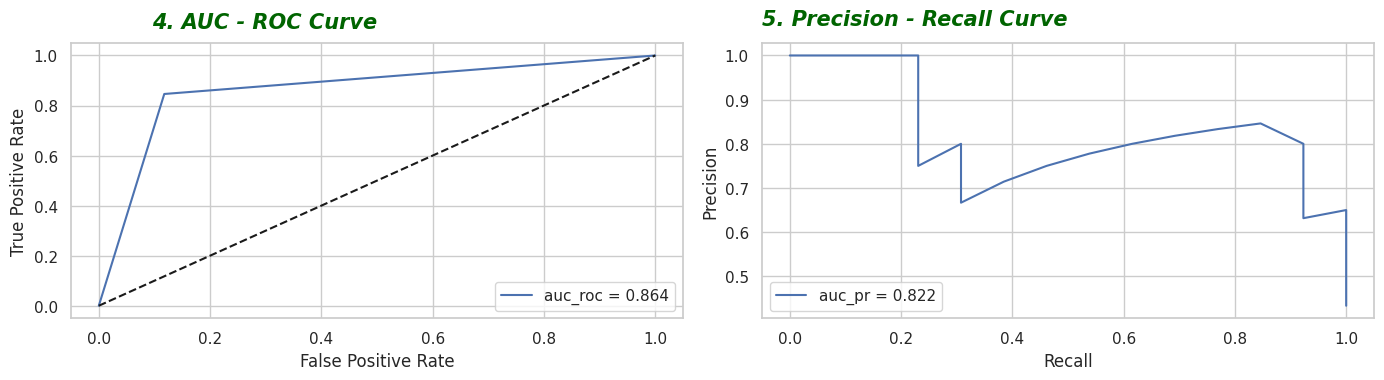

In [17]:
# SVM with Default Parameters and probability = True

svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

svm = svm.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(svm, X_test, y_test, model_name="Default Support Vector Machine")

### SVM Hyperparameters Tuning

In [18]:
# GridSearchCV to find best parameters for svm
svm = SVC(kernel = 'rbf', probability = True, random_state = 100)

# parameters to build the model on
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(estimator = svm, param_grid = param_grid,
                  scoring = 'accuracy', n_jobs = -1, cv = 5, verbose = 2)

# fitting the model for grid search
grid_search.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", grid_search.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", grid_search.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters: {'C': 100, 'gamma': 1}

Best Classifier: SVC(C=100, gamma=1, probability=True, random_state=100)


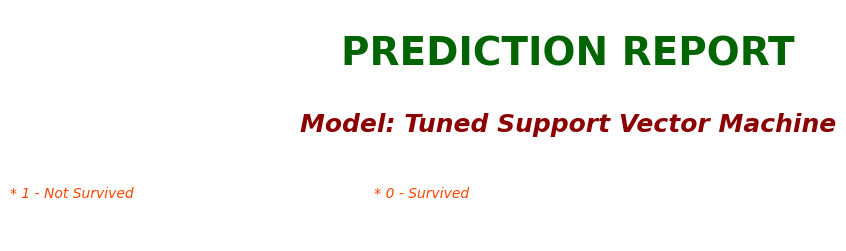

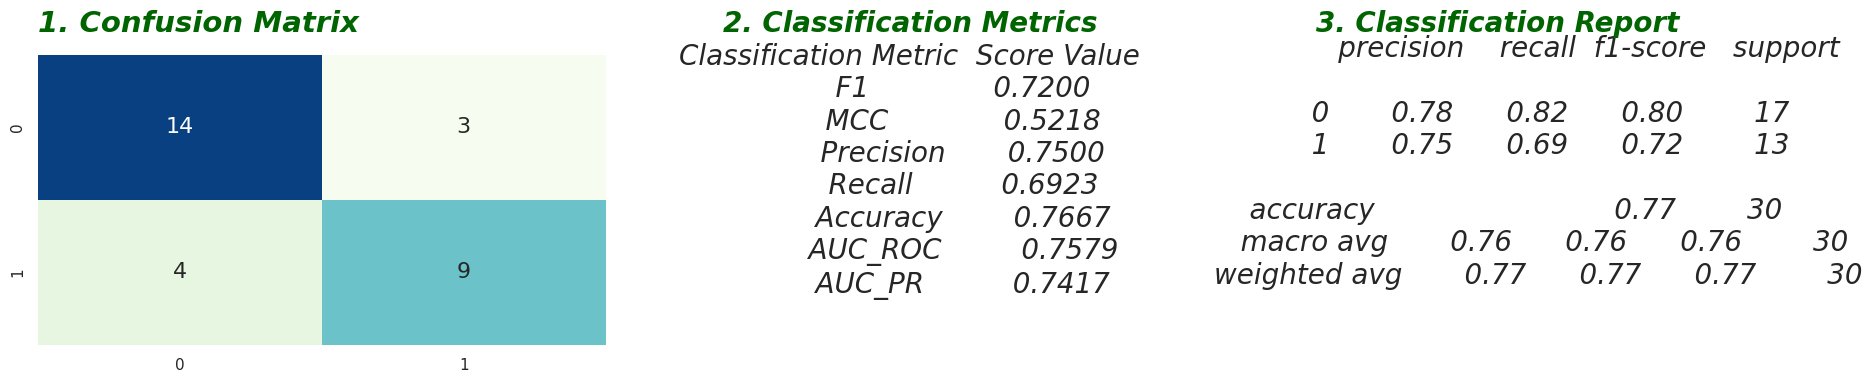

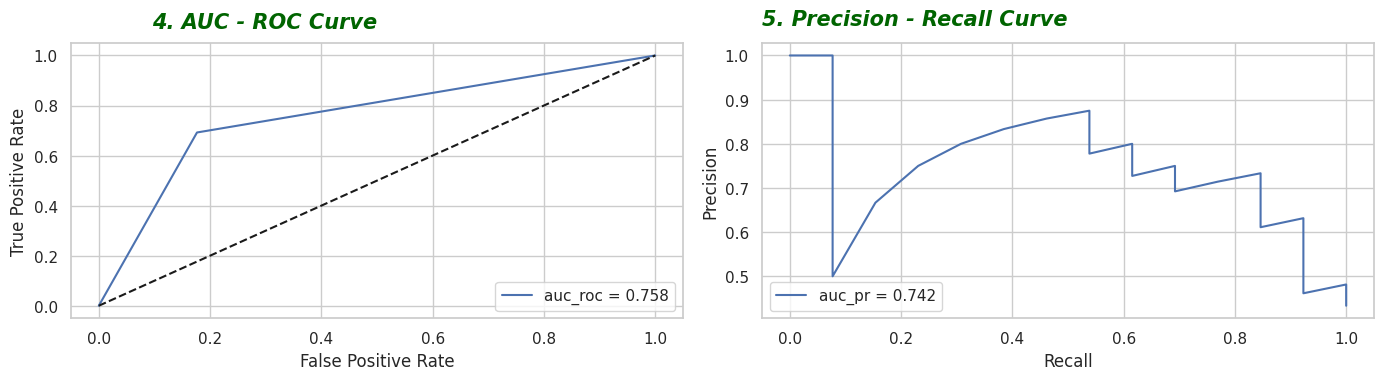

In [19]:
best_svc = grid_search.best_estimator_

best_svc.fit(X_train, y_train.values.ravel())


# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_svc, X_test, y_test, model_name="Tuned Support Vector Machine")

## 2. Decision Tree

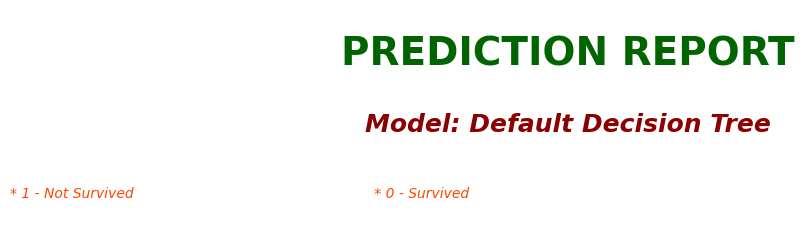

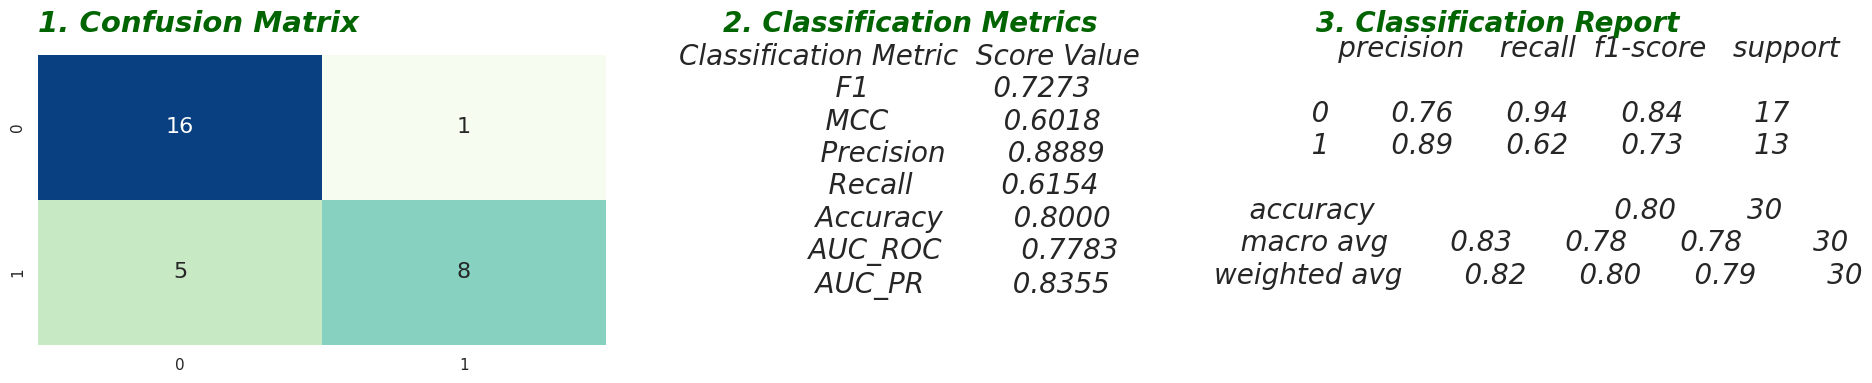

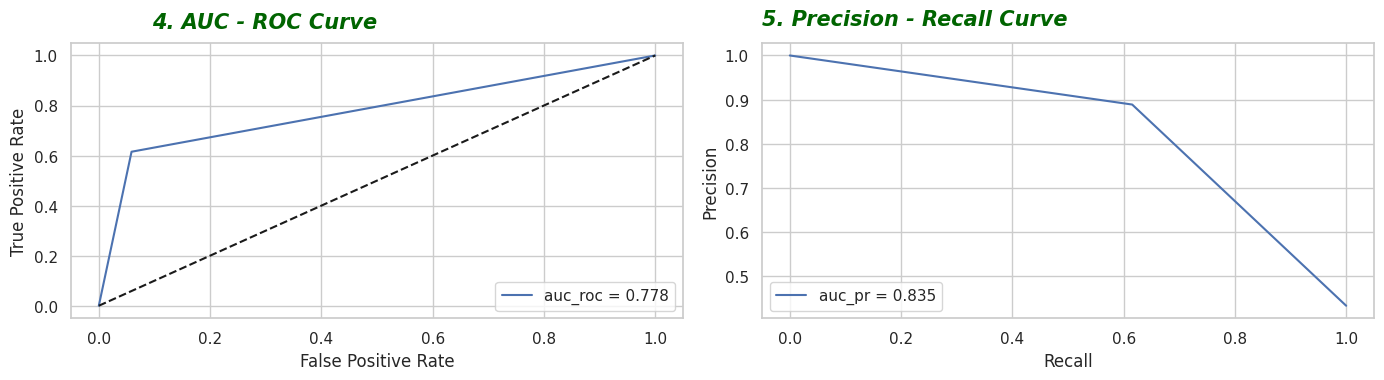

In [20]:
# Decision Tree with Default Parameters

tree = DecisionTreeClassifier(random_state = 100)

tree = tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(tree, X_test, y_test, model_name="Default Decision Tree")

### Decision Tree Hyperparameters Tuning

In [21]:
# GridSearchCV to find the optimal tree parameters
tree = DecisionTreeClassifier(random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 30),
#               "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "min_samples_split":range(2, 10),
              "criterion": ["gini", "entropy"]}

# Instantiating RandomizedSearchCV object
tree_grid = RandomizedSearchCV(tree, param_grid, cv = 5)

# fitting the model for grid search
tree_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", tree_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", tree_grid.best_estimator_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 26, 'min_samples_leaf': 4, 'min_samples_split': 7}

Best Classifier: DecisionTreeClassifier(criterion='entropy', max_depth=26, min_samples_leaf=4,
                       min_samples_split=7, random_state=100)


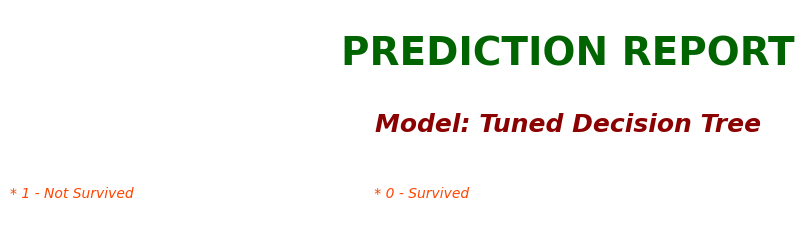

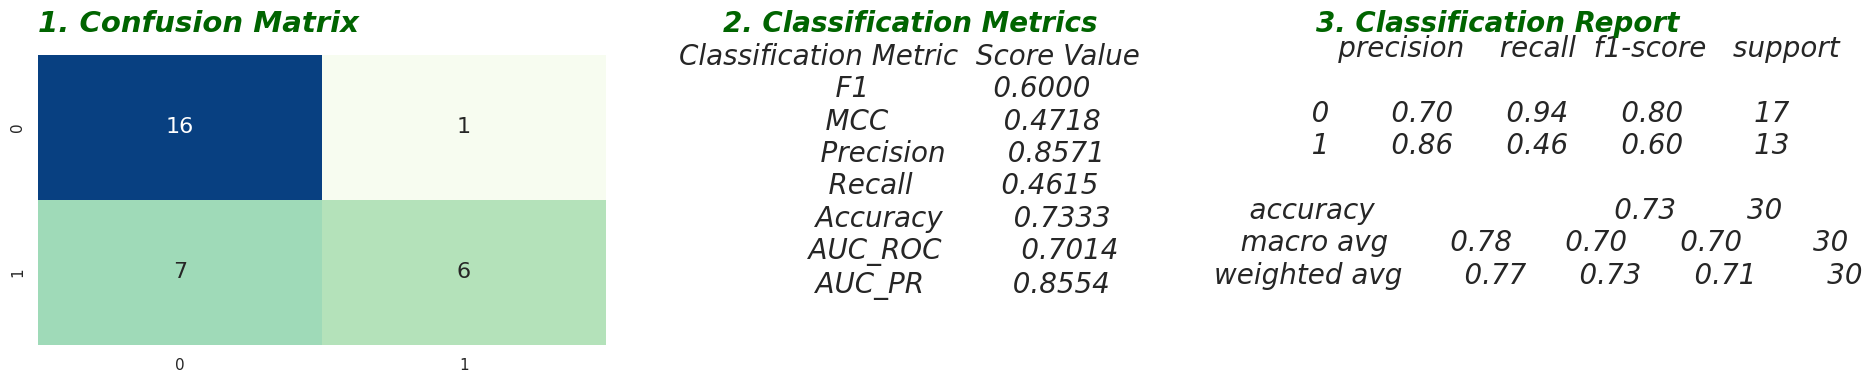

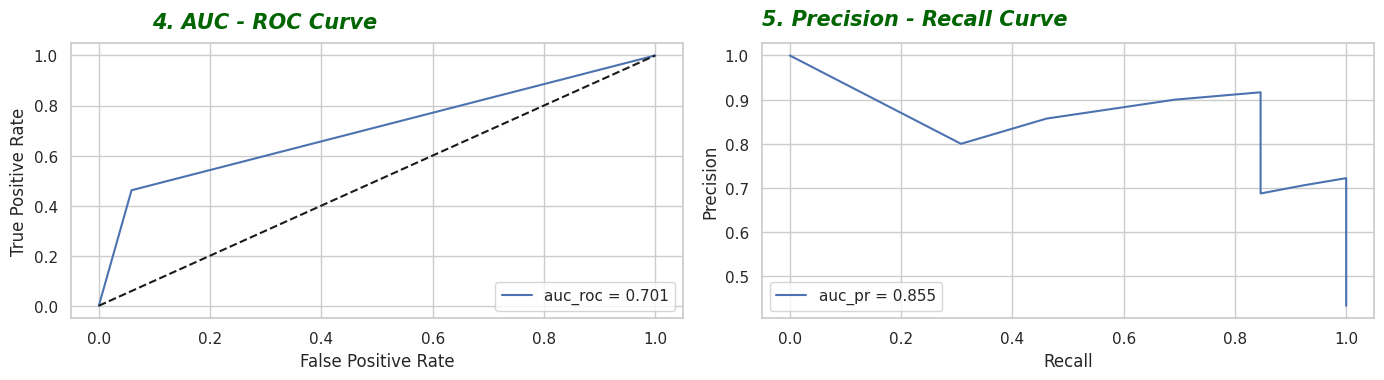

In [22]:
best_tree = tree_grid.best_estimator_

best_tree = best_tree.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_tree, X_test, y_test, model_name="Tuned Decision Tree")

## 3. Random Forest

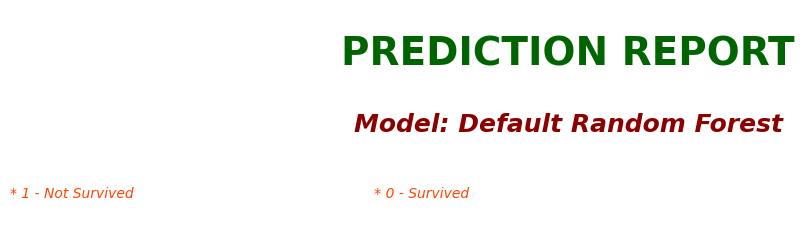

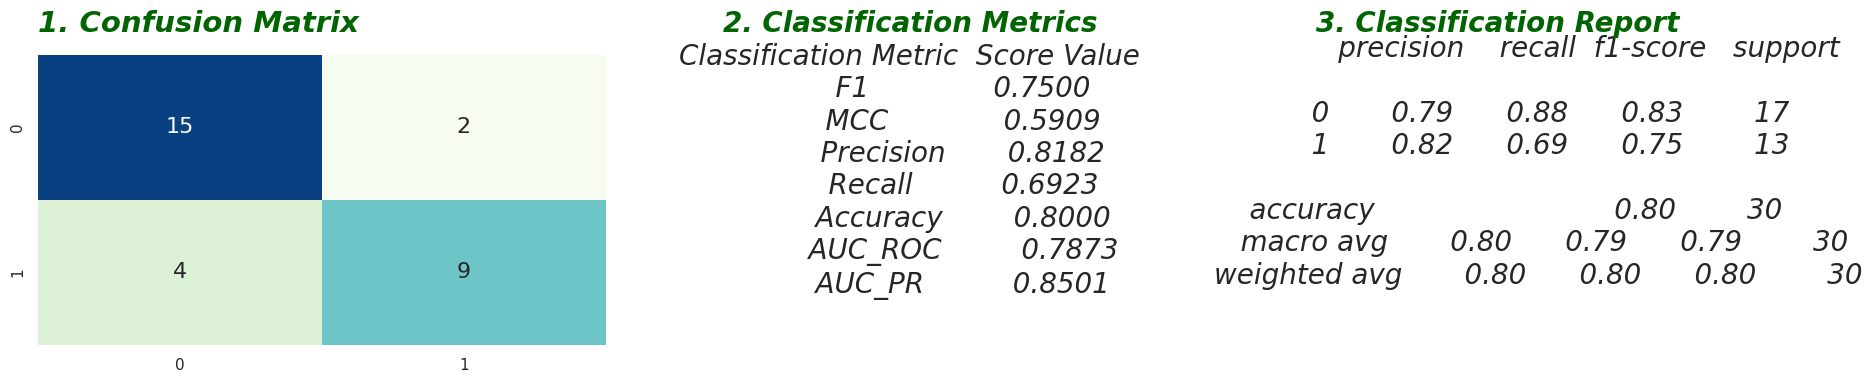

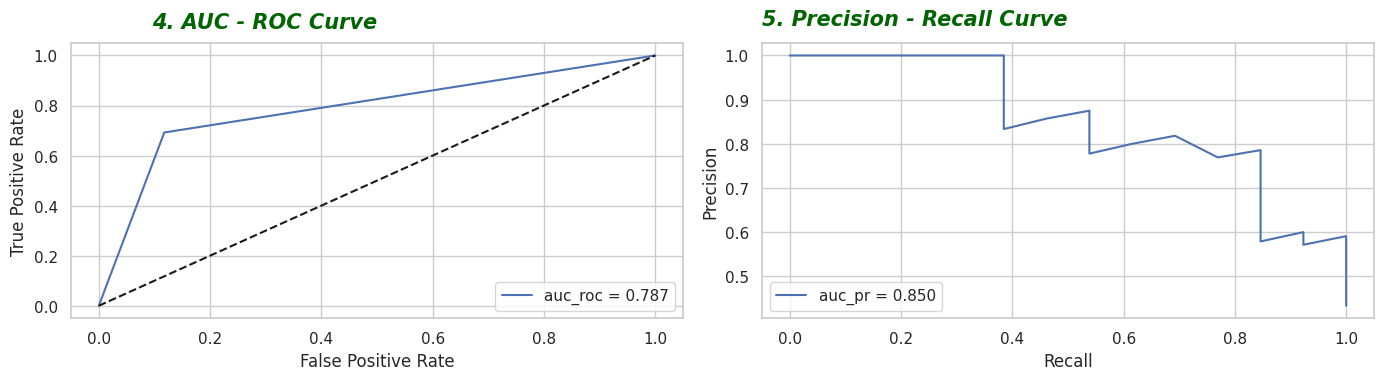

In [23]:
# Random Forest with Default Parameters
rfc = RandomForestClassifier(n_jobs = -1, random_state = 100)

rfc = rfc.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(rfc, X_test, y_test, model_name="Default Random Forest")

### Random Forest Hyperparameters Tuning

In [24]:
rn_forest = RandomForestClassifier(n_jobs = -1, random_state = 100)

# parameters to build the model on
param_grid = {"max_depth": range(1, 10),
#               "max_features": randint(1, 3),
              "min_samples_leaf": randint(25, 50),
              "min_samples_split":range(50, 100, 2),
              "n_estimators": range(1000, 8000, 500),
              "bootstrap": [True, False]}

# Instantiating RandomizedSearchCV object
forest_grid = RandomizedSearchCV(rn_forest, param_grid, cv = 5)

# fitting the model for grid search
forest_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", forest_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", forest_grid.best_estimator_)

Best Parameters: {'bootstrap': False, 'max_depth': 3, 'min_samples_leaf': 29, 'min_samples_split': 80, 'n_estimators': 1000}

Best Classifier: RandomForestClassifier(bootstrap=False, max_depth=3, min_samples_leaf=29,
                       min_samples_split=80, n_estimators=1000, n_jobs=-1,
                       random_state=100)


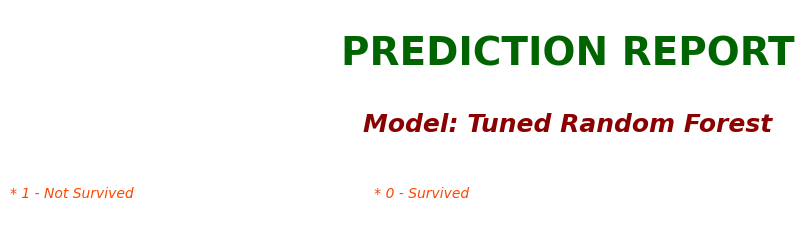

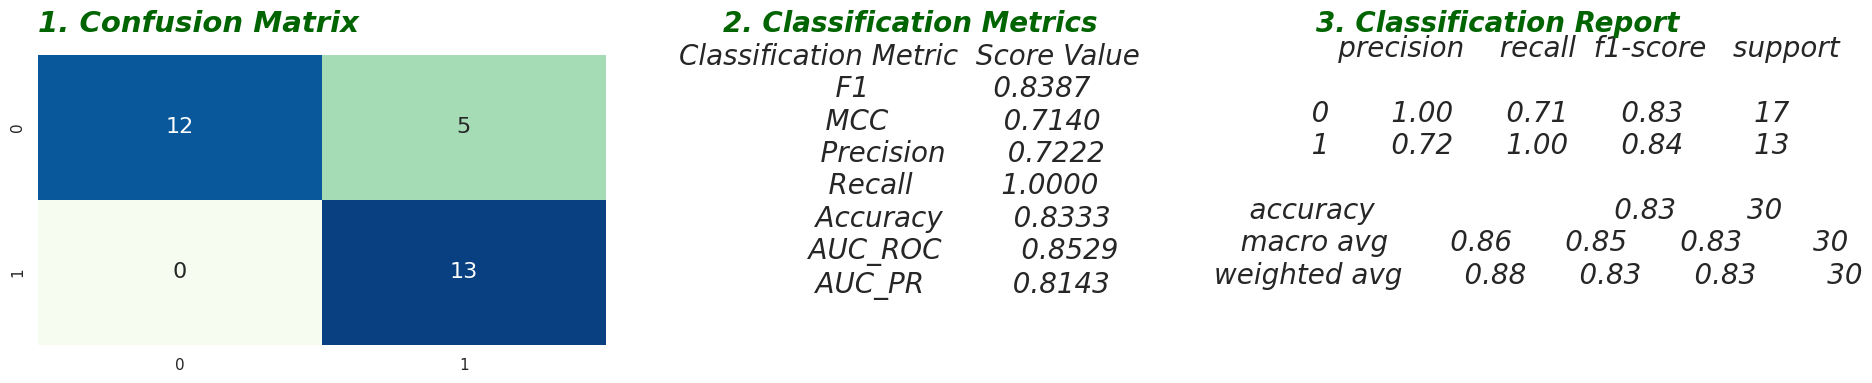

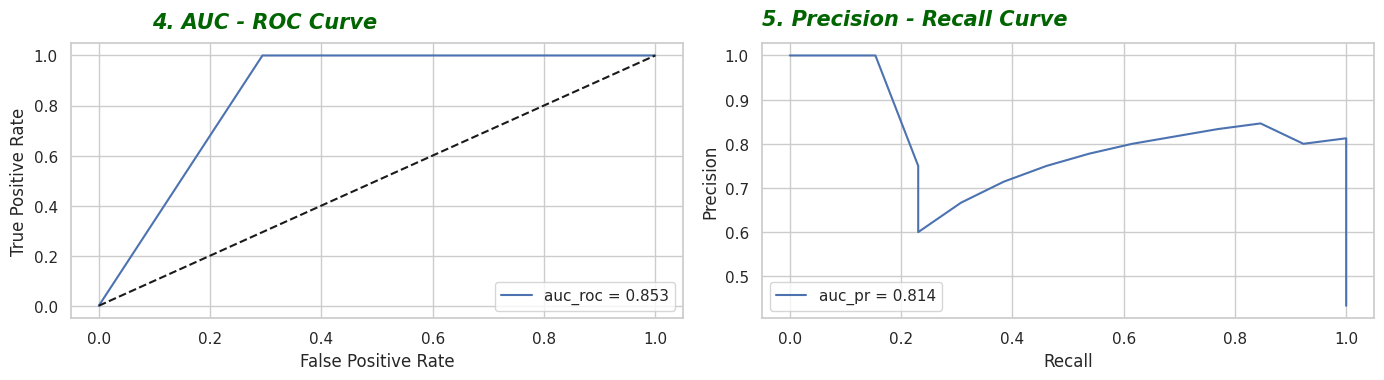

In [25]:
# Random Forest with Best Hypertuned Parameters
best_forest = forest_grid.best_estimator_

best_forest = best_forest.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_forest, X_test, y_test, model_name="Tuned Random Forest")

## 4. Extreme Gradient Boosting - XGBoost

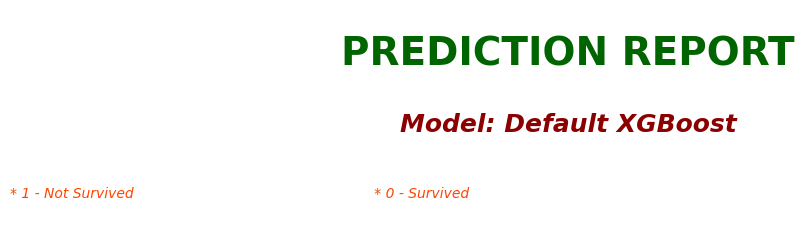

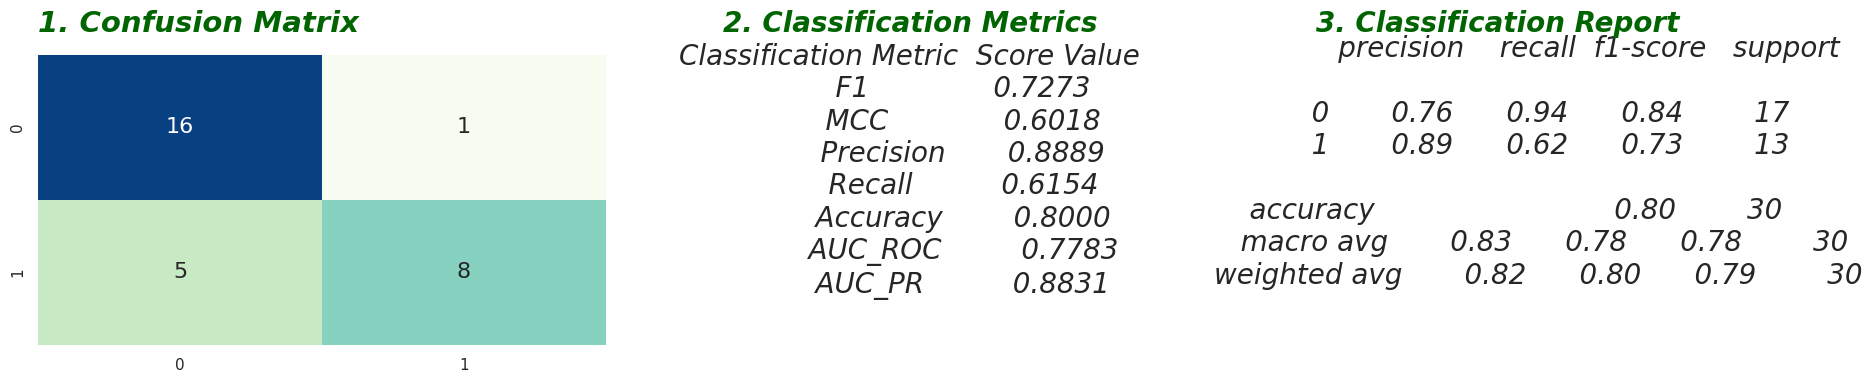

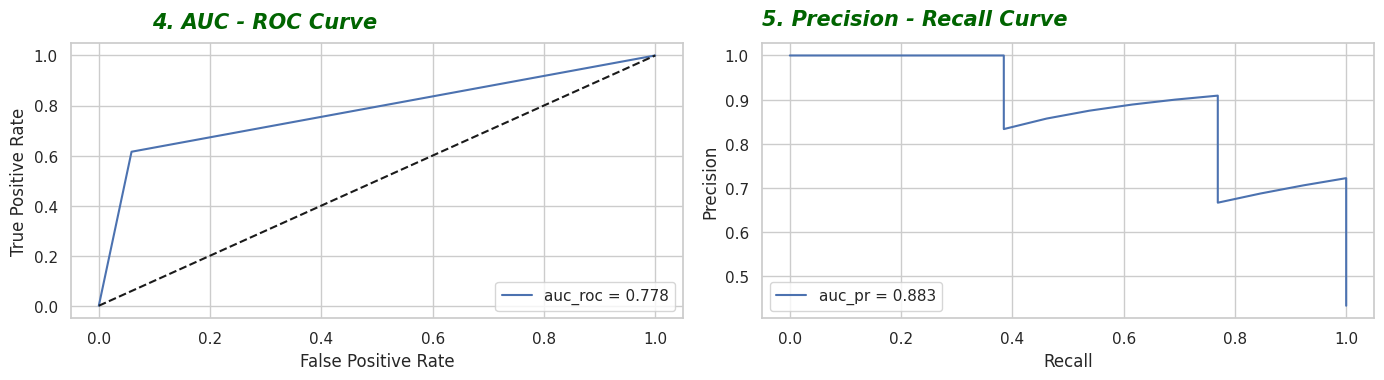

In [26]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

xgb = xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(xgb, X_test, y_test, model_name="Default XGBoost")

In [27]:
# utils.plot_model_feature_importances(X_train, model = xgb)
xgb.feature_importances_

array([0.38019857, 0.36328527, 0.25651616], dtype=float32)

### XG Boost Hyperparameters Tuning

In [28]:
# XGBoost with Default Parameters
xgb = XGBClassifier(n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
             'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.6, 0.9, 0.95, 0.99],
             'n_estimators': range(100, 1100, 100),
             'min_child_weight': range(1, 11),
             'subsample': np.arange(0.1, 1.1, 0.1),
             'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
xgb_grid = RandomizedSearchCV(xgb, param_grid, cv = 5)

# fitting the model for grid search
xgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", xgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", xgb_grid.best_estimator_)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 13, 'learning_rate': 0.3, 'colsample_bytree': 0.9}

Best Classifier: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=100, ...)


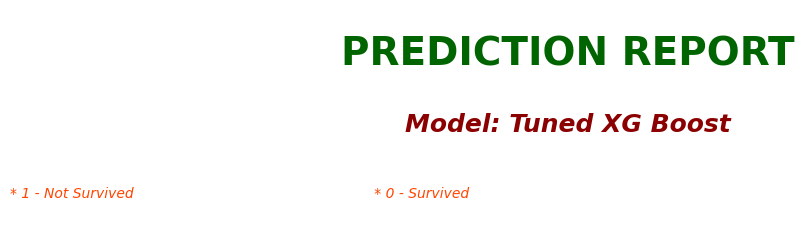

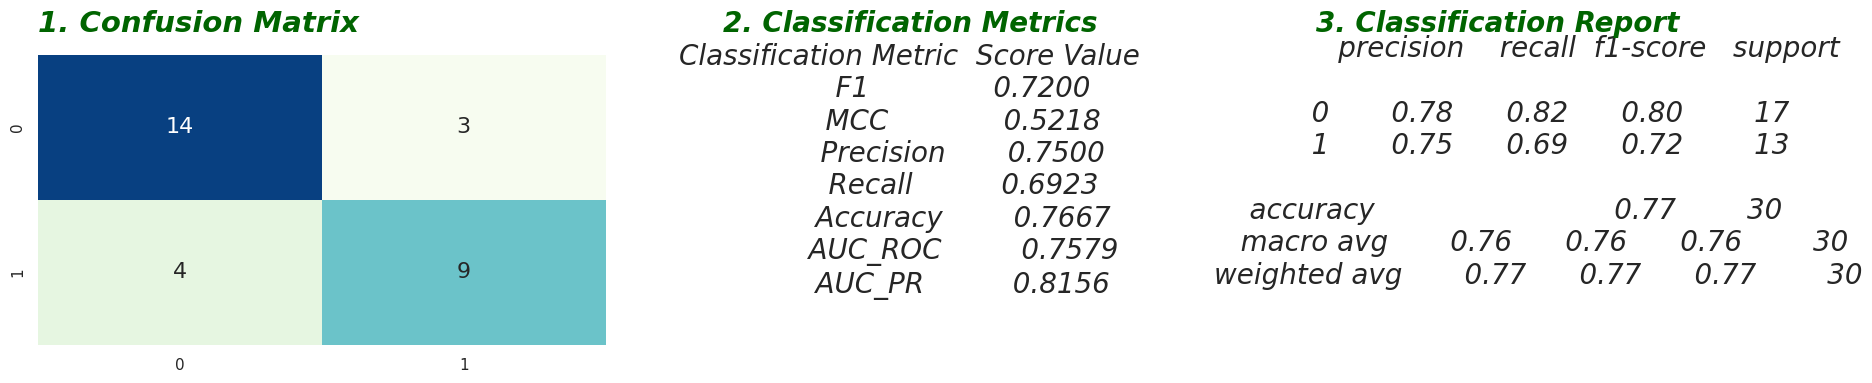

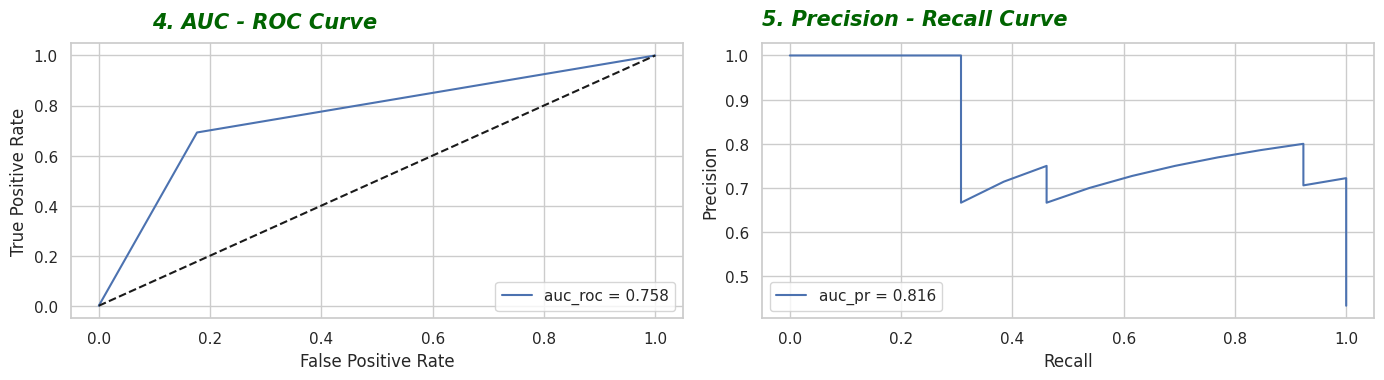

In [29]:
# XG Boost with Best Hypertuned Parameters
best_xgb = xgb_grid.best_estimator_

best_xgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_xgb, X_test, y_test, model_name="Tuned XG Boost")

## 5. Light Gradient Boosted Machine (Light GBM)

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

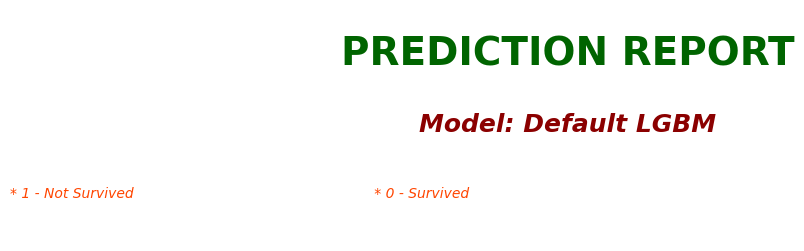

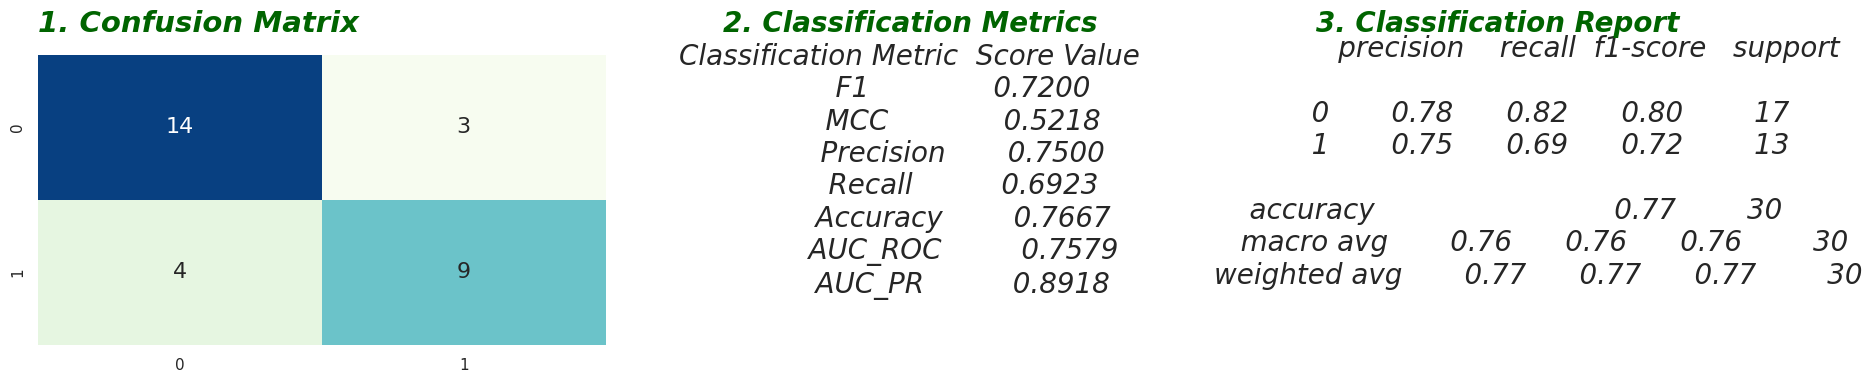

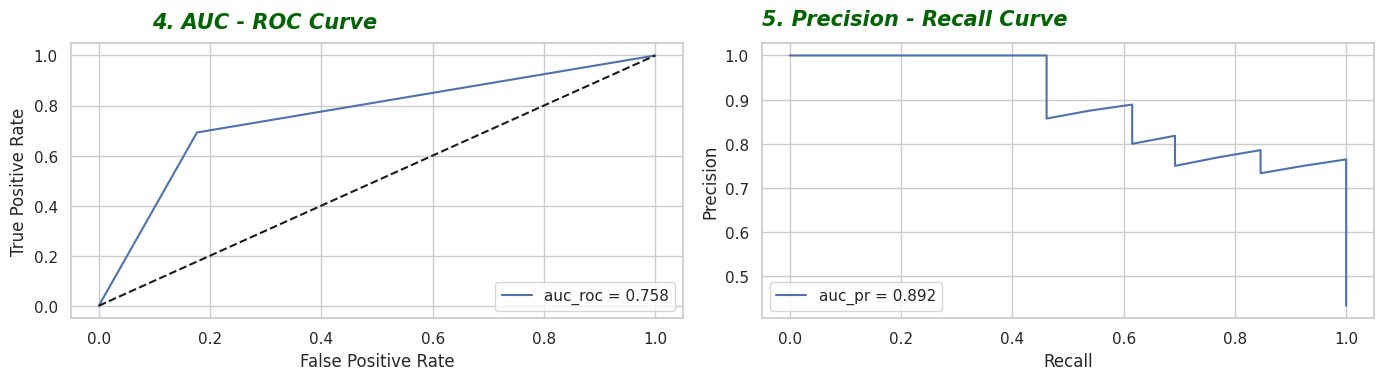

In [30]:
# LightGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(lgb, X_test, y_test, model_name="Default LGBM")

### LGBM Hyperparameter Tuning

In [31]:
# LGBM with Default Parameters
lgb = LGBMClassifier(objective = 'binary', n_jobs = -1, random_state = 100)

param_grid = {'max_depth': range(4, 40),
              'num_leaves': range(20, 100),
              'learning_rate': np.arange(0.1, 1.0, 0.1),
              'n_estimators': range(100, 1100, 100),
              'min_child_samples': range(1, 72),
              'subsample': np.arange(0.1, 1.1, 0.1),
              'colsample_bytree': np.arange(0.1, 1.1, 0.1)}

# Instantiating RandomizedSearchCV object
lgb_grid= RandomizedSearchCV(lgb, param_grid, cv = 5)

# fitting the model for grid search
lgb_grid = lgb_grid.fit(X_train, y_train.values.ravel())

# get the best parameter from gird search
print("Best Parameters:", lgb_grid.best_params_)

# get the best classifier model after hyper-parameter tuning
print("\nBest Classifier:", lgb_grid.best_estimator_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 137
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

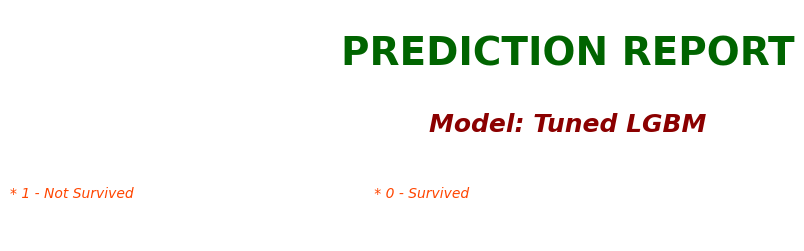

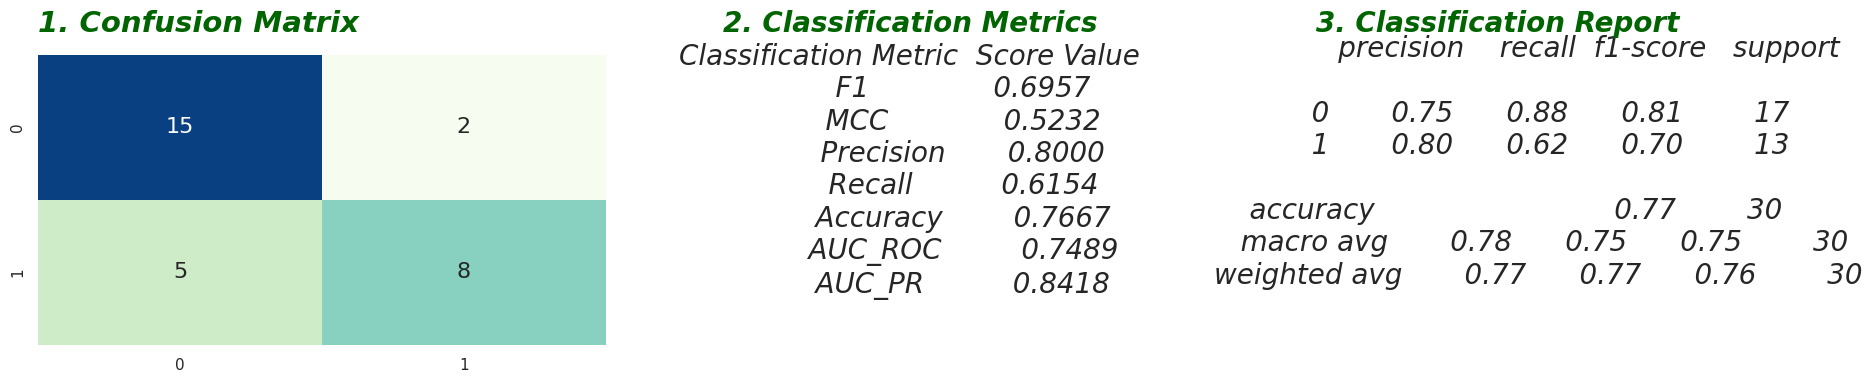

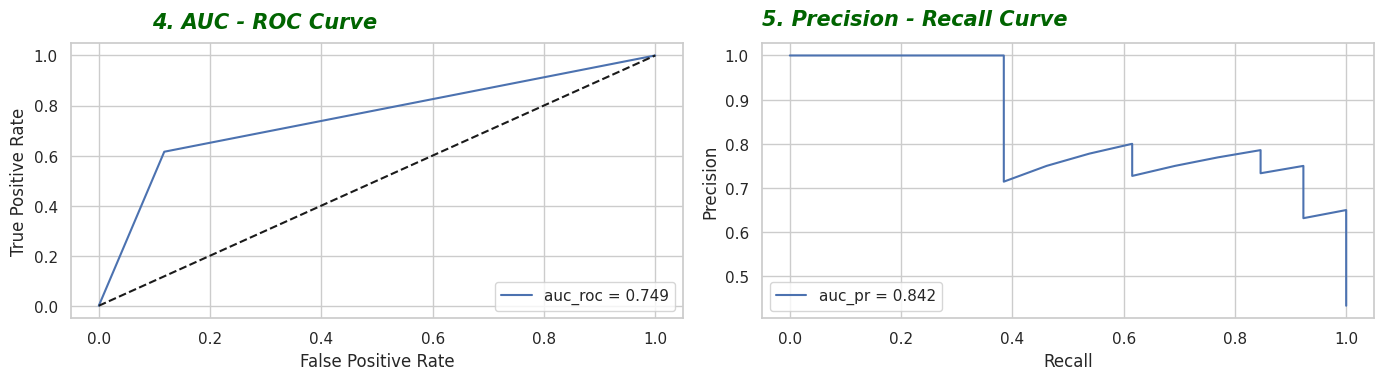

In [32]:
# LGBM with Best Hypertuned Parameters
best_lgb = lgb_grid.best_estimator_

best_lgb.fit(X_train, y_train.values.ravel())

# Generate the model test classification report
utils.Generate_Model_Test_Classification_Report(best_lgb, X_test, y_test, model_name="Tuned LGBM")

# Insights

**`1. 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time' seem to be the features that are more closely related to the death event.`**

**`2. The event of a heart failure in the old age could be fatal.`**

**`3. The levels of 'ejection_fraction', 'serum_creatinine', 'serum_sodium' play an important role in the event of heart failure or the abnormalities in the levels of these become an important factor in triggerring heart failure condition.`**

**`4. Random Forest, XGBoost and LightGBM turn out to be the better models in predicting the event of death given the vital parameters that effect heart failure of Cardiovascular conditions.`**

**`5. Machine Learning models can prove to be a time saving factor in predicting the event of death and can help the doctors take additional precauionary measures with critical care.`**

**`6. The imbalance in the dataset had been dealt using the SMOTE oversampling of the minority class. SMOTE balanced the no. of instances for each class but the amount of data is still limited.`**

**`7. The accuracy and model performance can be increased as more data is collected and made available for the model to train on. This data limitation, limits the model performance to some extent. As more data becomes available, the prediction accuracy and model's ability to act on other similar real-time data could be enhanced.`**